In [1]:
using Pkg
using DotEnv
using Images
using Plots

using FileIO, Images, MLDataUtils

using Plots
using Flux
using MLUtils: shuffleobs, splitobs
using MLDataUtils

using Flux: DataLoader
using Flux
using Statistics



# Data

In [2]:
function load_and_split_datasets(path_ships, path_icebergs)
    function load_images(folder_path, label)
        image_files = readdir(folder_path)
        images = [convert(Matrix{Float64}, Gray.(load(joinpath(folder_path, file)))) for file in image_files]
        labels = fill(label, length(images))
        return images, labels
    end

    function extract_data(data)
        images = [item[1] for item in data]
        labels = [item[2] for item in data]
        return images, labels
    end

    # Load images from folders
    ship_images, ship_labels = load_images(path_ships, 1)
    iceberg_images, iceberg_labels = load_images(path_icebergs, 0)

    # Combine and shuffle
    X = vcat(ship_images, iceberg_images)
    Y = vcat(ship_labels, iceberg_labels)
    data = shuffleobs(collect(zip(X, Y)))

    # Split the data
    (train_val, test) = splitobs(data, at=0.8)   # 80% for training+validation, 20% for test
    (train, val) = splitobs(train_val, at=0.75)  # 75% of 80% for training, 25% of 80% for validation

    # Extract images and labels
    train_X, train_Y = extract_data(train)
    val_X, val_Y = extract_data(val)
    test_X, test_Y = extract_data(test)

    return train_X, train_Y, val_X, val_Y, test_X, test_Y
end


load_and_split_datasets (generic function with 1 method)

In [3]:
train_X, train_Y, val_X, val_Y, test_X, test_Y = load_and_split_datasets("/Users/kaaso/Documents/coding/JuliaEO2024/data/ship no ship dataset/ship/png", "/Users/kaaso/Documents/coding/JuliaEO2024/data/ship no ship dataset/iceberg/png")

([[0.4994583047226673 0.5171435111009385 … 0.48221560997940033 0.5115434500648508; 0.5167925535973145 0.520485236896315 … 0.5184710460059511 0.49240863660639356; … ; 0.4971541924162661 0.4619974059662776 … 0.49088273441672386 0.4409094377050431; 0.5381399252307927 0.474189364461738 … 0.5055924315251392 0.5056687266346227], [0.5176012817578394 0.5170366979476616 … 0.5884794384679942 0.5828030823224232; 0.5103990234225986 0.48807507438773173 … 0.5637750820172427 0.5790188448920425; … ; 0.5296406500343328 0.5081254291599908 … 0.49878690775921264 0.5318379491874571; 0.5361562523842222 0.4927443350881209 … 0.5260090028229191 0.555718318455787], [0.5315022507057298 0.5249256122682536 … 0.5602807660028992 0.507362478065156; 0.5692835889219501 0.5048599984740978 … 0.5516594186312658 0.5432211795223926; … ; 0.5558861676966507 0.5212329289692531 … 0.5967193102922103 0.5501640344853895; 0.5386129549095903 0.5411306935225452 … 0.5578850995651179 0.5578850995651179], [0.503593499656672 0.5035934996

Label 0


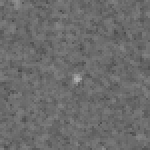

In [4]:
println("Label $(train_Y[7])")
Images.Gray.(train_X[7])


In [5]:
size(train_X), size(train_Y), size(val_X), size(val_Y), size(test_X), size(test_Y)

((962,), (962,), (321,), (321,), (321,), (321,))

# Make a simple binary classifier:

In [6]:
function create_model(; img_size=(75, 75), filter_size=3, num_filters=64, dense_units=128)
    # Calculate the size after first Conv and MaxPool
    conv1_size = div.(img_size .- (filter_size - 1), 2)
    
    # Calculate the size after second Conv and MaxPool
    conv2_size = div.(conv1_size .- (filter_size - 1), 2)

    # Number of features after flattening
    flattened_size = prod(conv2_size) * 2 * num_filters  # 2 * num_filters is the number of output channels

    return Chain(
        Flux.Conv((filter_size, filter_size), 1 => num_filters, relu),
        MaxPool((2,2)),
        Dropout(0.4),
        Flux.Conv((filter_size, filter_size), num_filters => 2 * num_filters, relu),
        MaxPool((2,2)),
        Dropout(0.4),
        Flux.Conv((filter_size, filter_size), 2 * num_filters => 2* num_filters, relu),
        Flux.flatten,
        Dense(flattened_size, dense_units, relu),
        Dense(dense_units, 1),
        sigmoid
    )
end

create_model (generic function with 1 method)

In [62]:
function create_model(; img_size=(75, 75), filter_size=3, num_filters=64, dense_units=128)
    # Adjust the flattened size calculation
    flattened_size = 18 * 18 * 2 * num_filters

    # Define the model
    return Chain(
        Conv((filter_size, filter_size), 1 => num_filters, relu),
        MaxPool((2,2)),
        Dropout(0.4),
        Conv((filter_size, filter_size), num_filters => 2 * num_filters, relu),
        MaxPool((2,2)),
        Dropout(0.4),
        Conv((filter_size, filter_size), 2 * num_filters => 2 * num_filters, relu),
        Flux.flatten,
        Dense(flattened_size, dense_units, relu),
        Dense(dense_units, 1),
        sigmoid
    )
end


create_model (generic function with 1 method)

In [65]:
function create_model(; img_size=(75, 75), filter_sizes=[3, 3, 3], num_filters=[64, 128, 256], dense_units=128)
    layers = []

    # Initial image dimensions
    current_dim = img_size

    # Add convolutional and pooling layers
    for i in 1:length(filter_sizes)
        filter_size = filter_sizes[i]
        n_filters = num_filters[i]
        
        # Add Conv layer
        push!(layers, Conv((filter_size, filter_size), (i == 1 ? 1 : num_filters[i-1]) => n_filters, relu))
        
        # Size reduction due to convolution
        current_dim = current_dim .- (filter_size - 1)

        # Add MaxPool layer
        push!(layers, MaxPool((2,2)))
        push!(layers, Dropout(0.4))

        # Size reduction due to pooling
        current_dim = div.(current_dim, 2)
    end

    # Calculate flattened size
    flattened_size = prod(current_dim) * num_filters[end]

    # Add fully connected layers
    push!(layers, Flux.flatten)
    push!(layers, Dense(flattened_size, dense_units, relu))
    push!(layers, Dense(dense_units, 1))
    push!(layers, sigmoid)

    return Chain(layers...)
end

create_model (generic function with 1 method)

In [9]:
function create_model(; 
    img_size=(75, 75), 
    filter_sizes=[3, 3, 3], 
    num_filters=[64, 128, 256], 
    use_maxpool=[true, true, true], 
    use_dropout=[true, true, true], 
    dense_layers=[128], 
    final_dense_units=1
)
layers = []

# Initial image dimensions
current_dim = img_size

# Add convolutional layers with optional pooling and dropout
for i in 1:length(filter_sizes)
    # Add Conv layer
    push!(layers, Conv((filter_sizes[i], filter_sizes[i]), (i == 1 ? 1 : num_filters[i-1]) => num_filters[i], relu))
    
    # Size reduction due to convolution
    current_dim = current_dim .- (filter_sizes[i] - 1)

    # Add MaxPool layer if specified
    if use_maxpool[i]
        push!(layers, MaxPool((2,2)))
        current_dim = div.(current_dim, 2)
    end

    # Add Dropout layer if specified
    if use_dropout[i]
        push!(layers, Dropout(0.4))
    end
end

# Calculate flattened size
flattened_size = prod(current_dim) * num_filters[end]

# Add flatten layer
push!(layers, Flux.flatten)

# Add additional dense layers
for dense_units in dense_layers
    push!(layers, Dense(flattened_size, dense_units, relu))
    flattened_size = dense_units  # Update for the next layer
end

# Add final dense layer
push!(layers, Dense(flattened_size, final_dense_units))
push!(layers, sigmoid)

return Chain(layers...)
end

create_model (generic function with 1 method)

In [ ]:
using Flux

function create_model(; 
        input_channels=1,  # Number of channels in input images
        img_size=(75, 75), 
        filter_sizes=[3, 3, 3], 
        num_filters=[64, 128, 256], 
        use_maxpool=[true, true, true], 
        use_dropout=[true, true, true], 
        dense_layers=[128], 
        final_dense_units=1
    )
    layers = []

    # Initial image dimensions
    current_dim = img_size

    # Add convolutional layers with optional pooling and dropout
    for i in 1:length(filter_sizes)
        # Determine the number of input channels for the Conv layer
        in_channels = i == 1 ? input_channels : num_filters[i-1]

        # Add Conv layer
        push!(layers, Conv((filter_sizes[i], filter_sizes[i]), in_channels => num_filters[i], relu))
        
        # Size reduction due to convolution
        current_dim = current_dim .- (filter_sizes[i] - 1)

        # Add MaxPool layer if specified
        if use_maxpool[i]
            push!(layers, MaxPool((2,2)))
            current_dim = div.(current_dim, 2)
        end

        # Add Dropout layer if specified
        if use_dropout[i]
            push!(layers, Dropout(0.4))
        end
    end

    # Calculate flattened size
    flattened_size = prod(current_dim) * num_filters[end]

    # Add flatten layer
    push!(layers, flatten)

    # Add additional dense layers
    for dense_units in dense_layers
        push!(layers, Dense(flattened_size, dense_units, relu))
        flattened_size = dense_units  # Update for the next layer
    end

    # Add final dense layer
    push!(layers, Dense(flattened_size, final_dense_units))
    push!(layers, sigmoid)

    return Chain(layers...)
end

# Example usage: model for RGB images
model_rgb = create_model(input_channels=3)


In [10]:
model = create_model(dense_layers = [128,56])

Chain(
  Conv((3, 3), 1 => 64, relu),          # 640 parameters
  MaxPool((2, 2)),
  Dropout(0.4),
  Conv((3, 3), 64 => 128, relu),        # 73_856 parameters
  MaxPool((2, 2)),
  Dropout(0.4),
  Conv((3, 3), 128 => 256, relu),       # 295_168 parameters
  MaxPool((2, 2)),
  Dropout(0.4),
  Flux.flatten,
  Dense(12544 => 128, relu),            # 1_605_760 parameters
  Dense(128 => 56, relu),               # 7_224 parameters
  Dense(56 => 1),                       # 57 parameters
  NNlib.σ,
)                   # Total: 12 arrays, 1_982_705 parameters, 7.565 MiB.

In [12]:
function train_model(model, train_X, train_Y, val_X, val_Y, epochs, learning_rate, batch_size)
    train_X_prepared = prepare_images(train_X)
    val_X_prepared = prepare_images(val_X)
    train_Y = reshape(Float32.(train_Y), 1, :)
    val_Y = reshape(Float32.(val_Y), 1, :)

    opt = ADAM(learning_rate)
    loss(x, y) = loss_fn(model(x), y)
    accuracy(x, y) = mean((model(x) .> 0.5) .== y)

    # Metrics storage
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in 1:epochs
        # Training
        train_loss = 0
        train_acc = 0
        count = 0
        for (x, y) in DataLoader((train_X_prepared, train_Y), batchsize=batch_size, shuffle=true)
            grads = gradient(Flux.params(model)) do
                l = loss(x, y)
                return l
            end
            Flux.update!(opt, Flux.params(model), grads)

            train_loss += loss(x, y)
            train_acc += accuracy(x, y)
            count += 1
        end
        push!(train_losses, train_loss / count)
        push!(train_accuracies, train_acc / count)

        # Validation
        val_loss = loss(val_X_prepared, val_Y)
        val_acc = accuracy(val_X_prepared, val_Y)
        push!(val_losses, val_loss)
        push!(val_accuracies, val_acc)

        @info "Epoch $epoch: Train Loss = $(train_losses[end]), Train Accuracy = $(train_accuracies[end]), Validation Loss = $(val_losses[end]), Validation Accuracy = $(val_accuracies[end])"
    end

    return train_losses, train_accuracies, val_losses, val_accuracies
end


train_model (generic function with 1 method)

In [13]:
function loss_fn(predictions, targets)
    # Ensure that predictions are clipped to avoid log(0)
    eps = 1e-7
    predictions = clamp.(predictions, eps, 1 - eps)
    return -mean(targets .* log.(predictions) + (1 .- targets) .* log.(1 .- predictions))
end


loss_fn (generic function with 1 method)

In [14]:

function prepare_images(images::Vector{Matrix{Float64}})
    # Convert to Float32 and add a singleton dimension for the channel and batch
    reshaped_images = [reshape(Float32.(image), size(image, 1), size(image, 2), 1, 1) for image in images]
    # Concatenate all images along the 4th dimension
    return cat(reshaped_images..., dims=4)
end


prepare_images (generic function with 1 method)

In [18]:
# Hyperparameters
epochs = 100
learning_rate = 0.0001
batch_size = 64

64

In [20]:
using Plots

# Train the model and get the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_X, train_Y, val_X, val_Y, epochs, learning_rate, batch_size)


┌ Info: Epoch 1: Train Loss = 0.6913948947257793, Train Accuracy = 0.5419921875, Validation Loss = 0.6921447339144146, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 2: Train Loss = 0.6904996389558451, Train Accuracy = 0.53515625, Validation Loss = 0.692483141490853, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 3: Train Loss = 0.6925859218274291, Train Accuracy = 0.5322265625, Validation Loss = 0.6923706046872607, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 4: Train Loss = 0.6912758847171377, Train Accuracy = 0.53515625, Validation Loss = 0.6921714025052611, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 5: Train Loss = 0.6926506997652739, Train Accuracy = 0.5048828125, Validation Loss = 0.6926488245150924, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 6: Train Loss = 0.691764094154342, Train Accuracy = 0.576171875, Validation Loss = 0.6921283298176936, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 7: Train Loss = 0.6907301150215863, Train Accuracy = 0.53515625, Validation Loss = 0.6918161129274879, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 8: Train Loss = 0.6913569127390065, Train Accuracy = 0.53515625, Validation Loss = 0.6920724134798805, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 9: Train Loss = 0.691648657247094, Train Accuracy = 0.53515625, Validation Loss = 0.6919452099861404, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 10: Train Loss = 0.6922206882271073, Train Accuracy = 0.5048828125, Validation Loss = 0.6919737607769877, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 11: Train Loss = 0.6920427869150799, Train Accuracy = 0.53515625, Validation Loss = 0.6919790689230871, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 12: Train Loss = 0.6898029244667947, Train Accuracy = 0.5654296875, Validation Loss = 0.6907860560786235, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 13: Train Loss = 0.6879749100015023, Train Accuracy = 0.5654296875, Validation Loss = 0.6903197475003269, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 14: Train Loss = 0.686642060641877, Train Accuracy = 0.5654296875, Validation Loss = 0.6897114183900553, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 15: Train Loss = 0.6890349061041017, Train Accuracy = 0.5048828125, Validation Loss = 0.6891860418826952, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 16: Train Loss = 0.6899280671636219, Train Accuracy = 0.5654296875, Validation Loss = 0.6892860939047011, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 17: Train Loss = 0.686087517889348, Train Accuracy = 0.5654296875, Validation Loss = 0.6851584164390827, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 18: Train Loss = 0.6849762976069732, Train Accuracy = 0.5048828125, Validation Loss = 0.6828166715404299, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 19: Train Loss = 0.6838403133975914, Train Accuracy = 0.533203125, Validation Loss = 0.6786404081811548, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 20: Train Loss = 0.6771540932131684, Train Accuracy = 0.51171875, Validation Loss = 0.6698574402880877, Validation Accuracy = 0.6822429906542056
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 21: Train Loss = 0.6563592759977932, Train Accuracy = 0.6357421875, Validation Loss = 0.6579168976631846, Validation Accuracy = 0.5046728971962616
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 22: Train Loss = 0.6563373229777196, Train Accuracy = 0.6748046875, Validation Loss = 0.6543990024980088, Validation Accuracy = 0.7507788161993769
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 23: Train Loss = 0.6255866886014494, Train Accuracy = 0.6298828125, Validation Loss = 0.6210603447606154, Validation Accuracy = 0.573208722741433
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 24: Train Loss = 0.6088243263002029, Train Accuracy = 0.6357421875, Validation Loss = 0.5871376357366231, Validation Accuracy = 0.573208722741433
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 25: Train Loss = 0.600122471148291, Train Accuracy = 0.7373046875, Validation Loss = 0.5799304682625448, Validation Accuracy = 0.6915887850467289
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 26: Train Loss = 0.5659739791259066, Train Accuracy = 0.720703125, Validation Loss = 0.5390295414099286, Validation Accuracy = 0.7601246105919003
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 27: Train Loss = 0.5295596737556747, Train Accuracy = 0.77734375, Validation Loss = 0.5499317868786016, Validation Accuracy = 0.6479750778816199
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 28: Train Loss = 0.5723158950687057, Train Accuracy = 0.7470703125, Validation Loss = 0.5548095025409734, Validation Accuracy = 0.7445482866043613
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 29: Train Loss = 0.5072491521758029, Train Accuracy = 0.78125, Validation Loss = 0.5298353426024394, Validation Accuracy = 0.6666666666666666
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 30: Train Loss = 0.5315492972054524, Train Accuracy = 0.76953125, Validation Loss = 0.5163740879398182, Validation Accuracy = 0.7507788161993769
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 31: Train Loss = 0.5671638052580232, Train Accuracy = 0.740234375, Validation Loss = 0.5644416940169455, Validation Accuracy = 0.7601246105919003
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 32: Train Loss = 0.5215089109929476, Train Accuracy = 0.7734375, Validation Loss = 0.5190088189125625, Validation Accuracy = 0.7570093457943925
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 33: Train Loss = 0.5154973551605001, Train Accuracy = 0.732421875, Validation Loss = 0.4910257807455321, Validation Accuracy = 0.7538940809968847
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 34: Train Loss = 0.4991331565896301, Train Accuracy = 0.7705078125, Validation Loss = 0.5184736959276495, Validation Accuracy = 0.6978193146417445
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 35: Train Loss = 0.487375453760601, Train Accuracy = 0.7939453125, Validation Loss = 0.48289238577026844, Validation Accuracy = 0.7507788161993769
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 36: Train Loss = 0.4347346498169256, Train Accuracy = 0.787109375, Validation Loss = 0.46781376150387066, Validation Accuracy = 0.7507788161993769
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 37: Train Loss = 0.4700418944904941, Train Accuracy = 0.767578125, Validation Loss = 0.4754622501448703, Validation Accuracy = 0.7507788161993769
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 38: Train Loss = 0.4341022909386024, Train Accuracy = 0.806640625, Validation Loss = 0.4641980849433924, Validation Accuracy = 0.7538940809968847
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 39: Train Loss = 0.43170782947569064, Train Accuracy = 0.810546875, Validation Loss = 0.46008172999263486, Validation Accuracy = 0.7289719626168224
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 40: Train Loss = 0.4468537021377571, Train Accuracy = 0.779296875, Validation Loss = 0.46297944166895605, Validation Accuracy = 0.7289719626168224
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 41: Train Loss = 0.4202330983303654, Train Accuracy = 0.8115234375, Validation Loss = 0.4860624262181864, Validation Accuracy = 0.719626168224299
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 42: Train Loss = 0.412263218215345, Train Accuracy = 0.810546875, Validation Loss = 0.5131596523196509, Validation Accuracy = 0.7320872274143302
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 43: Train Loss = 0.4228731984591822, Train Accuracy = 0.8212890625, Validation Loss = 0.48487483512097546, Validation Accuracy = 0.719626168224299
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 44: Train Loss = 0.39871969366139387, Train Accuracy = 0.810546875, Validation Loss = 0.4595529205717787, Validation Accuracy = 0.7320872274143302
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 45: Train Loss = 0.4438715457228434, Train Accuracy = 0.8037109375, Validation Loss = 0.4716048366432434, Validation Accuracy = 0.7414330218068536
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 46: Train Loss = 0.4076511679193942, Train Accuracy = 0.78515625, Validation Loss = 0.4643665260487811, Validation Accuracy = 0.7383177570093458
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 47: Train Loss = 0.45708838773330984, Train Accuracy = 0.775390625, Validation Loss = 0.493199324560732, Validation Accuracy = 0.7414330218068536
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 48: Train Loss = 0.4203286111649254, Train Accuracy = 0.8115234375, Validation Loss = 0.4415664991564748, Validation Accuracy = 0.7694704049844237
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 49: Train Loss = 0.39823507890614207, Train Accuracy = 0.8173828125, Validation Loss = 0.4470320733515021, Validation Accuracy = 0.7663551401869159
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 50: Train Loss = 0.399025573801629, Train Accuracy = 0.8173828125, Validation Loss = 0.5105075889042214, Validation Accuracy = 0.735202492211838
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 51: Train Loss = 0.4004401074549159, Train Accuracy = 0.82421875, Validation Loss = 0.5316640376390758, Validation Accuracy = 0.7227414330218068
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 52: Train Loss = 0.4482847194714079, Train Accuracy = 0.7939453125, Validation Loss = 0.46580112629479636, Validation Accuracy = 0.7632398753894081
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 53: Train Loss = 0.40668438172818894, Train Accuracy = 0.8193359375, Validation Loss = 0.4327438645759237, Validation Accuracy = 0.7725856697819314
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 54: Train Loss = 0.4201041366782316, Train Accuracy = 0.7822265625, Validation Loss = 0.4686193871953458, Validation Accuracy = 0.7632398753894081
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 55: Train Loss = 0.42442388427030064, Train Accuracy = 0.8154296875, Validation Loss = 0.4549898266554284, Validation Accuracy = 0.7538940809968847
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 56: Train Loss = 0.4118581562127111, Train Accuracy = 0.8173828125, Validation Loss = 0.4385834765458217, Validation Accuracy = 0.7725856697819314
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 57: Train Loss = 0.38020124120836396, Train Accuracy = 0.8330078125, Validation Loss = 0.4330203058371938, Validation Accuracy = 0.7757009345794392
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 58: Train Loss = 0.3847381436574138, Train Accuracy = 0.7978515625, Validation Loss = 0.4876069657884656, Validation Accuracy = 0.7414330218068536
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 59: Train Loss = 0.4117978659816071, Train Accuracy = 0.8251953125, Validation Loss = 0.4391121444377169, Validation Accuracy = 0.7725856697819314
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 60: Train Loss = 0.366187792157005, Train Accuracy = 0.8134765625, Validation Loss = 0.5172065414057366, Validation Accuracy = 0.735202492211838
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 61: Train Loss = 0.3754731345747914, Train Accuracy = 0.8291015625, Validation Loss = 0.4651818878955329, Validation Accuracy = 0.7507788161993769
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 62: Train Loss = 0.37027088718685, Train Accuracy = 0.82421875, Validation Loss = 0.4534694202088025, Validation Accuracy = 0.7538940809968847
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 63: Train Loss = 0.36886633439432337, Train Accuracy = 0.8310546875, Validation Loss = 0.4805632853951814, Validation Accuracy = 0.7383177570093458
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 64: Train Loss = 0.3890051408499937, Train Accuracy = 0.8173828125, Validation Loss = 0.44110786453582135, Validation Accuracy = 0.778816199376947
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 65: Train Loss = 0.4399447604413166, Train Accuracy = 0.7705078125, Validation Loss = 0.5438097337958956, Validation Accuracy = 0.7258566978193146
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 66: Train Loss = 0.4745153098792272, Train Accuracy = 0.7705078125, Validation Loss = 0.44512071905333855, Validation Accuracy = 0.794392523364486
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 67: Train Loss = 0.39316877966159325, Train Accuracy = 0.8251953125, Validation Loss = 0.4213377555657383, Validation Accuracy = 0.7757009345794392
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 68: Train Loss = 0.39151167704490375, Train Accuracy = 0.806640625, Validation Loss = 0.4434694634289498, Validation Accuracy = 0.7694704049844237
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 69: Train Loss = 0.46145104421435446, Train Accuracy = 0.7841796875, Validation Loss = 0.44423937382780004, Validation Accuracy = 0.7819314641744548
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 70: Train Loss = 0.4026176118683496, Train Accuracy = 0.802734375, Validation Loss = 0.43701866024414715, Validation Accuracy = 0.778816199376947
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 71: Train Loss = 0.372283592979388, Train Accuracy = 0.8359375, Validation Loss = 0.4214242714166776, Validation Accuracy = 0.7881619937694704
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 72: Train Loss = 0.3941633353901697, Train Accuracy = 0.8310546875, Validation Loss = 0.45714431376363757, Validation Accuracy = 0.7570093457943925
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 73: Train Loss = 0.36296309476044636, Train Accuracy = 0.8388671875, Validation Loss = 0.4362998166722547, Validation Accuracy = 0.778816199376947
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


┌ Info: Epoch 74: Train Loss = 0.3737910356043245, Train Accuracy = 0.8388671875, Validation Loss = 0.4380862697324847, Validation Accuracy = 0.7850467289719626
└ @ Main /Users/kaaso/Documents/coding/JuliaEO2024/Notebooks/2. Ship binary classification.ipynb:42


In [106]:
function calculate_accuracy(predictions, labels)
    thresholded_predictions = predictions .> 0.5
    return mean(thresholded_predictions .== labels)
end

function calculate_precision(predictions, labels)
    thresholded_predictions = predictions .> 0.5
    true_positives = sum((thresholded_predictions .== 1) .& (labels .== 1))
    predicted_positives = sum(thresholded_predictions)
    return predicted_positives == 0 ? 0 : true_positives / predicted_positives
end

function calculate_recall(predictions, labels)
    thresholded_predictions = predictions .> 0.5
    true_positives = sum((thresholded_predictions .== 1) .& (labels .== 1))
    actual_positives = sum(labels)
    return actual_positives == 0 ? 0 : true_positives / actual_positives
end

function calculate_f1_score(predictions, labels)
    precision = calculate_precision(predictions, labels)
    recall = calculate_recall(predictions, labels)
    return precision + recall == 0 ? 0 : 2 * (precision * recall) / (precision + recall)
end


calculate_f1_score (generic function with 1 method)

In [143]:
function calculate_class_metrics(predictions, true_labels, threshold, class_label)
    pred_labels = predictions .> threshold
    tp = sum((pred_labels .== class_label) .& (true_labels .== class_label))
    fp = sum((pred_labels .== class_label) .& (true_labels .!= class_label))
    tn = sum((pred_labels .!= class_label) .& (true_labels .!= class_label))
    fn = sum((pred_labels .!= class_label) .& (true_labels .== class_label))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / length(true_labels)

    return (precision=precision, recall=recall, f1=f1, accuracy=accuracy)
end

function calculate_metrics(predictions, true_labels, threshold)
    ship_metrics = calculate_class_metrics(predictions, true_labels, threshold, 1)
    iceberg_metrics = calculate_class_metrics(predictions, true_labels, threshold, 0)

    return (threshold=threshold, ships=ship_metrics, icebergs=iceberg_metrics)
end

function compute_metrics_vector(predictions, labels, thresholds)
    metrics_vector = []

    for t in thresholds
        metrics = calculate_metrics(predictions, labels, t)
        push!(metrics_vector, metrics)
    end

    return metrics_vector
end


compute_metrics_vector (generic function with 1 method)

In [90]:
val_X_prepared = prepare_images(val_X) # Use the same prepare_images function
val_labels = reshape(Float32.(val_Y), 1, :) # Reshape labels
val_predictions = model(val_X_prepared)



1×321 Matrix{Float32}:
 0.379979  0.388845  0.47288  0.996803  …  0.403536  0.420284  0.515391

In [146]:
thresholds = 0:0.05:1
metrics_vector = compute_metrics_vector(val_predictions, val_labels, thresholds)


21-element Vector{Any}:
 (threshold = 0.0, ships = (precision = 0.53, recall = 1.0, f1 = 0.6928104575163399, accuracy = 0.53), icebergs = (precision = NaN, recall = 0.0, f1 = NaN, accuracy = 0.53))
 (threshold = 0.05, ships = (precision = 0.5257731958762887, recall = 0.9622641509433962, f1 = 0.68, accuracy = 0.52), icebergs = (precision = 0.3333333333333333, recall = 0.02127659574468085, f1 = 0.04, accuracy = 0.52))
 (threshold = 0.1, ships = (precision = 0.5161290322580645, recall = 0.9056603773584906, f1 = 0.6575342465753424, accuracy = 0.5), icebergs = (precision = 0.2857142857142857, recall = 0.0425531914893617, f1 = 0.07407407407407407, accuracy = 0.5))
 (threshold = 0.15, ships = (precision = 0.5168539325842697, recall = 0.8679245283018868, f1 = 0.647887323943662, accuracy = 0.5), icebergs = (precision = 0.36363636363636365, recall = 0.0851063829787234, f1 = 0.13793103448275862, accuracy = 0.5))
 (threshold = 0.2, ships = (precision = 0.5308641975308642, recall = 0.81132075471698

In [145]:
# For ships at the first threshold
println(metrics_vector[1].ships.precision)

# For icebergs at the first threshold
println(metrics_vector[1].icebergs.precision)


0.53
NaN


In [147]:
using Plots

# Function to plot metrics for ships and icebergs
function plot_combined_metrics(metrics_vector, metric_name)
    thresholds = [m.threshold for m in metrics_vector]
    ships_metric = [getfield(m.ships, metric_name) for m in metrics_vector]
    icebergs_metric = [getfield(m.icebergs, metric_name) for m in metrics_vector]

    plot(thresholds, ships_metric, label="Ships $(metric_name)", title="$(metric_name) vs Threshold")
    plot!(thresholds, icebergs_metric, label="Icebergs $(metric_name)", xlabel="Threshold", ylabel=metric_name)
end


plot_combined_metrics (generic function with 1 method)

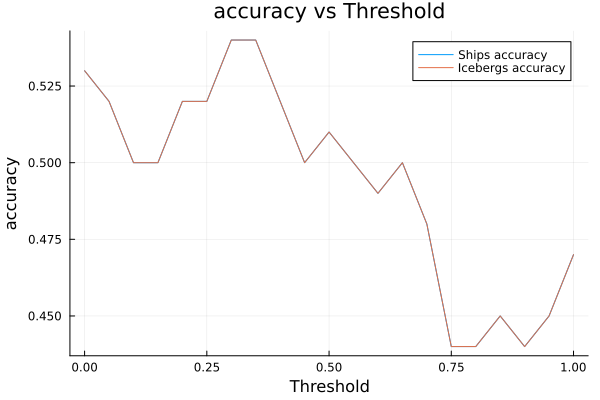

In [149]:
# Assuming metrics_vector contains your metrics data as previously computed
plot_combined_metrics(metrics_vector, :accuracy)

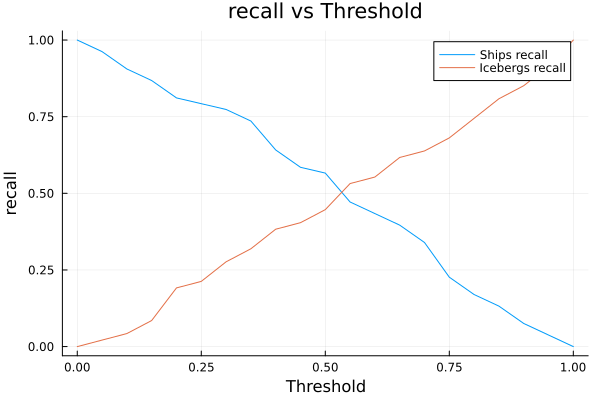

In [150]:
plot_combined_metrics(metrics_vector, :recall)

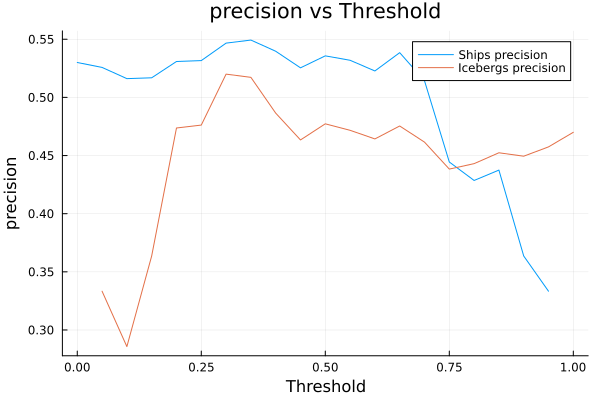

In [151]:
plot_combined_metrics(metrics_vector, :precision)

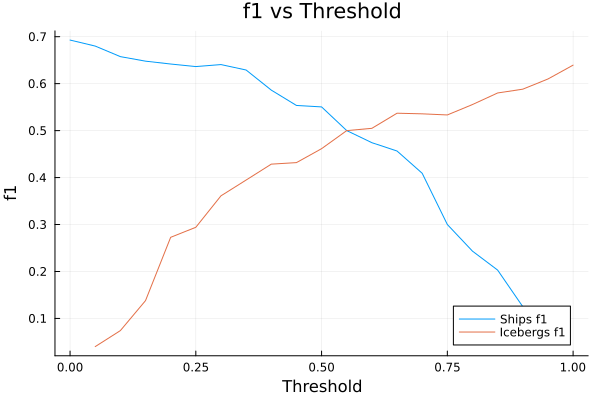

In [152]:
plot_combined_metrics(metrics_vector, :f1)


In [ ]:
# To save the plot to a file
p = plot_combined_metrics(metrics_vector, :accuracy)
savefig(p, "accuracy_vs_threshold.png")


# test set

In [159]:
function evaluate_test_set_at_threshold(test_predictions, test_labels, threshold)
    # Ensure that test_labels are in the correct format (a vector, not a matrix)
    if typeof(test_labels) == Matrix
        test_labels = vec(test_labels)
    end
    
    # Ensure predictions are a vector if they are not already
    if typeof(test_predictions) == Matrix
        test_predictions = vec(test_predictions)
    end
    
    # Calculate metrics for ships
    ship_metrics = calculate_class_metrics(test_predictions, test_labels, threshold, 1)
    
    # Calculate metrics for icebergs
    iceberg_metrics = calculate_class_metrics(test_predictions, test_labels, threshold, 0)
    
    return (ships=ship_metrics, icebergs=iceberg_metrics)
end

# Function to calculate class metrics with positive_class as a required argument
function calculate_class_metrics(predictions, true_labels, threshold, class_label)
    pred_labels = predictions .> threshold
    tp = sum((pred_labels .== class_label) .& (true_labels .== class_label))
    fp = sum((pred_labels .== class_label) .& (true_labels .!= class_label))
    tn = sum((pred_labels .!= class_label) .& (true_labels .!= class_label))
    fn = sum((pred_labels .!= class_label) .& (true_labels .== class_label))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    accuracy = (tp + tn) / length(true_labels)

    return (precision=precision, recall=recall, f1=f1, accuracy=accuracy)
end

# Apply the function to your test set
# Replace `model(test_X)` with your actual model's predictions on the test set
# Replace `test_Y` with your actual test labels
# Replace `specific_threshold` with the threshold you have determined from your validation set

test_metrics = evaluate_test_set_at_threshold(test_predictions, test_labels, 0.9)

# The `test_metrics` will contain the metrics for both ships and icebergs at the specified threshold
println("Test Metrics at threshold $specific_threshold:")
println("Ships - Precision: $(test_metrics.ships.precision), Recall: $(test_metrics.ships.recall), F1 Score: $(test_metrics.ships.f1), Accuracy: $(test_metrics.ships.accuracy)")
println("Icebergs - Precision: $(test_metrics.icebergs.precision), Recall: $(test_metrics.icebergs.recall), F1 Score: $(test_metrics.icebergs.f1), Accuracy: $(test_metrics.icebergs.accuracy)")


Test Metrics at threshold 0.5:
Ships - Precision: 1.0, Recall: 0.24096385542168675, F1 Score: 0.38834951456310685, Accuracy: 0.6074766355140186
Icebergs - Precision: 0.5516014234875445, Recall: 1.0, F1 Score: 0.7110091743119267, Accuracy: 0.6074766355140186
